<a href="https://colab.research.google.com/github/MarBry111/DeepLearning/blob/main/CIFAR10_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn
from tqdm.notebook import tqdm
 
from functools import partial
from collections import OrderedDict

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.__version__)

1.8.1+cu101


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)
 
testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#px.imshow(torch.movedim(trainset[0][0], 0, 2))
px.imshow(trainset[0][0].numpy()[0])

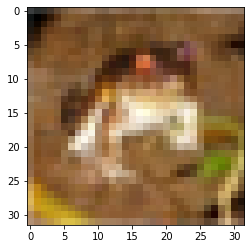

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(trainset[0][0])

In [ ]:
classes[trainset[0][1]]

'frog'

In [ ]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
def test(net, dataloader, device='cuda:0'):
    net = net.to(device)
    conf_matrix = np.zeros((10, 10))
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = net(X)
            pred_cls = pred.argmax(1)
            for j in range(len(pred_cls)):
                conf_matrix[y[j]][pred_cls[j]] += 1
    return conf_matrix

In [ ]:
def train(net, dataloader, optimizer, loss_func, epochs=100, device='cuda:0', scheduler=None):
    n = len(trainloader.dataset)
    net.to(device)
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in tqdm(range(epochs)):
        epoch_ok = 0
        
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = net(X)
            loss = loss_func(pred, y)
            
            train_loss[epoch] += loss.item()
            pred_cls = pred.argmax(1)
            epoch_ok += sum(pred_cls == y)
            
            loss.backward()
            optimizer.step()
        
        if scheduler: scheduler.step()
        
        conf_matrix = test(net, testloader)    
        test_acc[epoch] = np.diag(conf_matrix).sum() / np.sum(conf_matrix)
        train_acc[epoch] = epoch_ok / n
        
        print(f'Epoch {epoch}: train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.3f}, '
              f'test acc: {test_acc[epoch]}')
    
    return  train_acc, test_acc, train_loss, test_loss

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.gap = nn.MaxPool2d(kernel_size=(8,8))
        
        self.linear = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU()
        )
        
    
    def forward(self, x):
        # conv block
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = self.conv3(x)
        x = self.gap(F.relu(x))
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
    

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.gap = nn.MaxPool2d(kernel_size=(16, 16))
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        # conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.gap(x)

        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
    

In [ ]:
class ResNet01(nn.Module):
    
    def __init__(self):
        super(ResNet01, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv11 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv1to11 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(1,1), padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv22 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv2to22 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1,1), padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv33 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv3to33 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding=0)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.conv44 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1)
        self.conv4to44 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.res_layer_1 = nn.Sequential(
            self.conv11(),
            self.bn1(),
            F.relu(),
            self.conv11(),
            self.bn1()
        )
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        identity = self.conv1to11(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv11(x)
        x = self.bn1(x)
        x += identity
        x = F.relu(x)
 
        identity = x
        x = self.conv11(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv11(x)
        x = self.bn1(x)
        x += identity
        x = F.relu(x)
 
        identity = self.conv2to22(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv22(x)
        x = self.bn2(x)
        x += identity
        x = F.relu(x)
        
        identity = x
        x = self.conv22(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv22(x)
        x = self.bn2(x)
        x += identity
        x = F.relu(x)
 
        identity = self.conv3to33(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv33(x)
        x = self.bn3(x)
        x += identity
        x = F.relu(x)
        
        identity = x
        x = self.conv33(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv33(x)
        x = self.bn3(x)
        x += identity
        x = F.relu(x)
 
        identity = self.conv4to44(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv44(x)
        x = self.bn4(x)
        x += identity
        x = F.relu(x)
        
        identity = x
        x = self.conv44(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv44(x)
        x = self.bn4(x)
        x += identity
        x = F.relu(x)
 
        x = self.gap(x)
 
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x

In [ ]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )


    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

 
class ResBlockSimple(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
 
    def forward(self, inputs):
        return self.module(inputs) + inputs
 
class ResNet02(nn.Module):
    def __init__(self, classes=10, simpnet_name='ResNet02'):
        super(ResNet02, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
 
        self.residual_net = self._make_layers()
 
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 10),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.residual_net(x)
        x = self.gap(x)
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
 
    def _make_layers(self):
 
        model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(16),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(16, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(16),
                    nn.Conv2d(16, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(16),
                )
            ),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(16, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(16),
                    nn.Conv2d(16, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(16),
                )
            ),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(32, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(32),
                    nn.Conv2d(32, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(32),
                )
            ),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(32, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(32),
                    nn.Conv2d(32, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(32),
                )
            ),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(64),
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(64),
                )
            ),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(64),
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(64),
                )
            ),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(128),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(128),
                )
            ),
            ResBlockSimple(
                nn.Sequential(
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(128),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(128),
                )
            )
 
        )
 
        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
 
        return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
net = ResNet02().to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()
sgd = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(sgd, step_size=5, gamma=2)

In [ ]:
train(net, trainloader, sgd, loss_func, 10)

Epoch 0: train loss: 454.9094, train acc: 0.904, test acc: 0.809
Epoch 1: train loss: 428.5620, train acc: 0.910, test acc: 0.7953
Epoch 2: train loss: 420.9768, train acc: 0.912, test acc: 0.8081


In [ ]:
mx = test(net, trainloader)

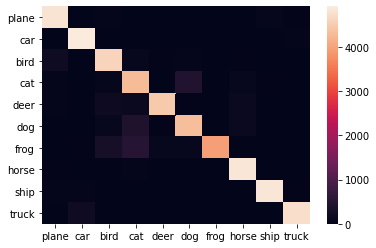

In [ ]:
mx_df = pd.DataFrame(mx)
mx_df.columns = classes
mx_df.index = classes
sn.heatmap(mx_df)

- lr scheduler,
- 